In [2]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('broadway_original.webp')

In [2]:
def compute_energy_v1(image):
    """
    Compute the energy of an image using the Sobel operator.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Convert to grayscale
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5) # Sobel operator in x direction
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5) # Sobel operator in y direction
    # Compute the energy map as the sum of the absolute values of the gradients
    # The Sobel operator returns floating point values, so we need to convert them to uint8
    energy = np.abs(sobel_x) + np.abs(sobel_y)
    return energy.astype(np.uint8)

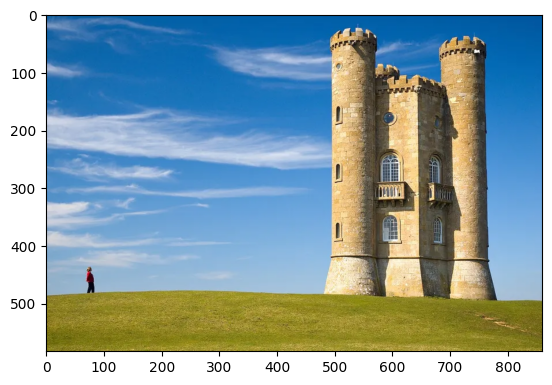

In [3]:
#show the original image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [4]:
def find_seam_v1(image,energy):
    """
    Find the seam with the lowest energy in the image.
    """
    energy = compute_energy_v1(image) # Compute the energy of the image
    rows, cols = energy.shape # Get the dimensions of the image
    seam = np.zeros((rows,), dtype=int) # Initialize the seam array
    dp = np.zeros((rows, cols), dtype=np.float32) # Initialize the dynamic programming table

    dp[0] = energy[0] # The first row is just the energy of the first row

    for i in range(1, rows):
        for j in range(cols):
            if j == 0: ## If we are at the first column
                dp[i][j] = energy[i][j] + min(dp[i-1][j], dp[i-1][j+1])
            elif j == cols - 1: ## If we are at the last column
                dp[i][j] = energy[i][j] + min(dp[i-1][j-1], dp[i-1][j])
            else: # If we are in the middle columns
                dp[i][j] = energy[i][j] + min(dp[i-1][j-1], dp[i-1][j], dp[i-1][j+1])

    seam[-1] = np.argmin(dp[-1]) # The last element of the seam is the column with the minimum value in the last row of dp

    for i in range(rows - 2, -1, -1):
        j = seam[i + 1] 
        if j == 0:
            seam[i] = j if dp[i][j] < dp[i][j + 1] else j + 1
        elif j == cols - 1:
            seam[i] = j if dp[i][j] < dp[i][j - 1] else j - 1
        else:
            seam[i] = j if dp[i][j] < min(dp[i][j - 1], dp[i][j + 1]) else (j - 1 if dp[i][j - 1] < dp[i][j + 1] else j + 1)

    return seam

In [5]:
def remove_seam_v1(image, seam):
    """
    Remove the seam from the image.
    """
    rows, cols, _ = image.shape # Get the dimensions of the image
    new_image = np.zeros((rows, cols - 1, 3), dtype=image.dtype) # Create a new image with one less column

    for i in range(rows):
        j = seam[i]
        new_image[i, :j] = image[i, :j] # Copy the pixels to the left of the seam
        new_image[i, j:] = image[i, j + 1:] # Copy the pixels to the right of the seam

    return new_image

In [6]:
# Main function to run the seam carving algorithm
def seam_carving_v1(image, num_seams):
    """
    Perform seam carving on the image.
    """
    rows, cols, _ = image.shape # Get the dimensions of the image
    energy = compute_energy_v1(image) # Compute the energy of the image
    rows, cols = energy.shape # Get the dimensions of the image
    for _ in range(num_seams):
        seam = find_seam_v1(image,energy) # Find the seam with the lowest energy
        image = remove_seam_v1(image, seam) # Remove the seam from the image
    return image

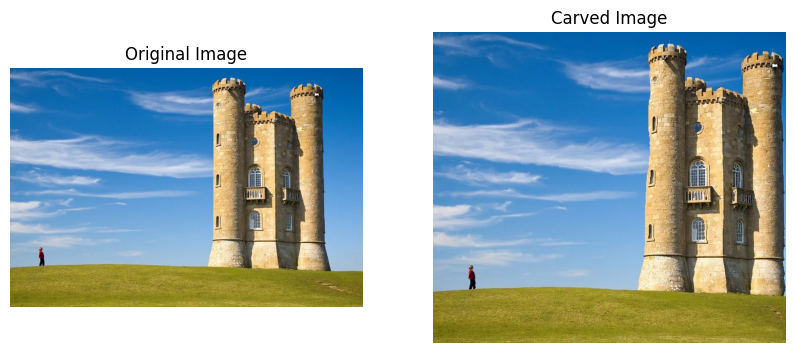

In [7]:
#test the seam carving algorithm
num_seams = 200 # Number of seams to remove
carved_image = seam_carving_v1(image, num_seams) # Perform seam carving
# Display the original and carved images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(carved_image, cv2.COLOR_BGR2RGB))
plt.title('Carved Image')
plt.axis('off')
plt.show() # Show the images



# Naive Seam Carving Implementation

This first proof-of-concept version works correctly, but introduces two major performance bottlenecks:

1. **Wrong choose of the seam to take of**
    We select some seamns that are important to the picture

2. **Full energy map recomputation**  
   After removing each seam, we recalculate the energy for **every** pixel in the image, turning what could be an almost linear process into quadratic (or worse) time complexity.

3. **Fresh seam search each iteration**  
   We search for the minimal‐energy path “from scratch” on every removal, without reusing prior results (no dynamic programming table), which further multiplies the runtime.

Original Image Shape: (583, 860, 3)
Carved Image Shape: (583, 660, 3)


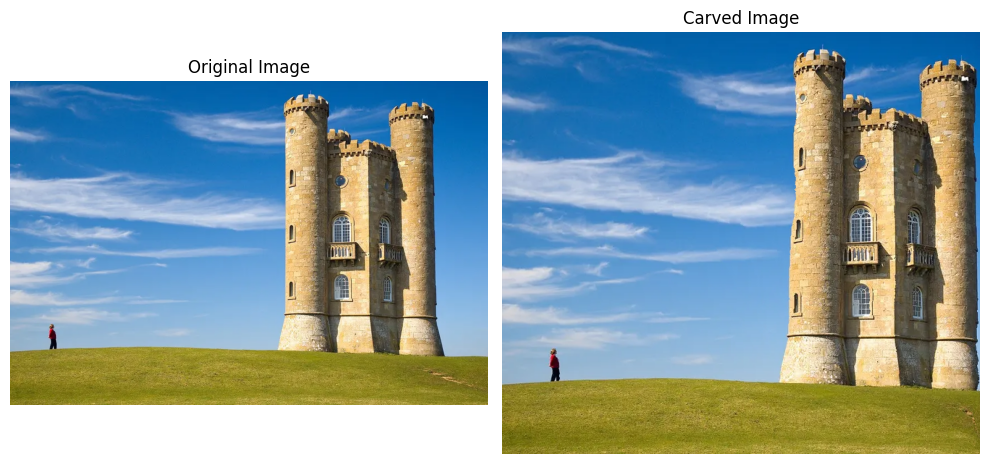

In [8]:
# Display the original and carved images with axis labels
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(carved_image, cv2.COLOR_BGR2RGB))
plt.title('Carved Image')
plt.axis('off')

plt.tight_layout()

print("Original Image Shape:", image.shape)
print("Carved Image Shape:", carved_image.shape)


plt.show()

### Improvements and Design Choices

- **Full encapsulation of the pipeline**  
  The entire seam-carving workflow—energy computation ➔ seam finding ➔ seam removal—is wrapped in the `SeamCarver` class. This means you can instantiate an object once and call a single method (`seam_carve`) to drive the process from end to end. Encapsulation makes unit testing easier (each method can be tested in isolation) and encourages code reuse: you can swap out energy functions or seam-finding strategies without touching the rest of the code.

- **Per-iteration energy recalculation**  
  Rather than computing the energy map once on the original image, we recalculate it on the *current* image at the start of each seam removal iteration. This preserves the correct energy gradient around newly formed “holes” and guarantees that each subsequent seam is chosen based on the image’s up-to-date structure. Empirically this yields more visually coherent results, especially when removing many seams.

- **Flexible energy parameterization**  
  By passing a string flag (`'l1'`, `'l2'`, `'HoG'`, etc.) to `compute_energy`, you can experiment with different saliency measures without duplicating logic. All energy functions share the same signature, so adding a new method (e.g. an entropy-based measure or learned saliency) requires only one more `elif` branch. This design keeps the code DRY and makes comparative evaluation straightforward.

- **Seam history for insertion and analysis**  
  Removed seam indices are appended to `self.history` along with their orientation. This allows two powerful extensions:  
  1. **Seam insertion / “content amplification”**, where you reverse the removal order to grow the image back out.  
  2. **Debugging and visualization**, by replaying which seams were cut in which order.  
  Maintaining a removal log opens the door to advanced retargeting modes (bidirectional resizing, guided removal, etc.).

- **Unified orientation handling**  
  `find_seam` takes an `orientation` argument (`'vertical'` or `'horizontal'`), transposes the energy map when needed, and then runs the same DP/backtracking logic. This avoids code duplication and ensures that any bugfix in one orientation automatically applies to the other. It also makes future extensions (e.g. `diagonal`) trivial to slot in.

- **Clear separation of concerns**  
  - `compute_energy` focuses solely on producing a saliency map.  
  - `find_seam` handles dynamic-programming and backtracking to locate the minimal path.  
  - `remove_seam` takes care of image data manipulation.  
  - `seam_carve` orchestrates the high-level loop.  
  By keeping these responsibilities distinct, each component remains small, well-documented, and testable.

Together, these object-oriented design decisions make the implementation modular, easy to extend, and ready for experimentation with new energy functions, insertion schemes, or optimization strategies. You can drop in a novel saliency measure, refine the DP backtracking, or build a GUI around the class—all without rewriting the core logic.

In [10]:
from class_SeamCarver import SeamCarver

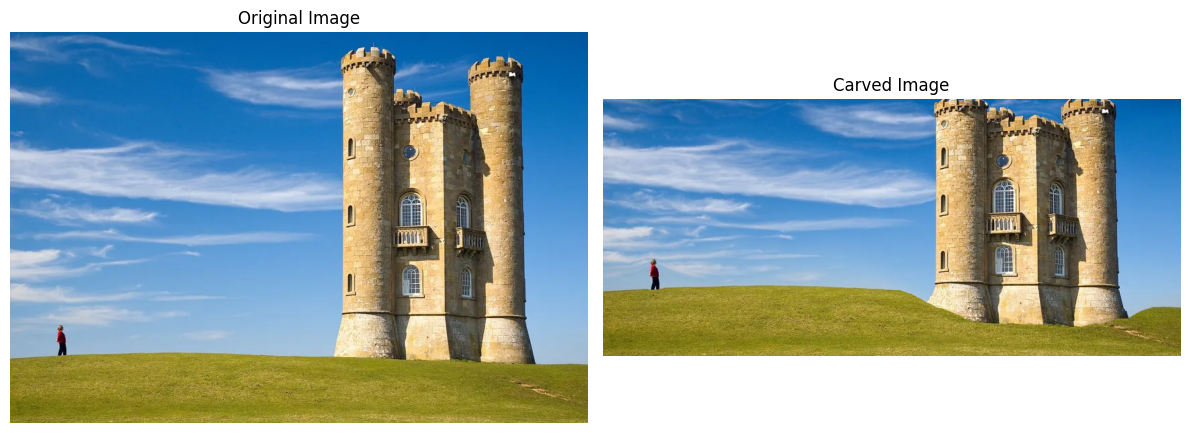

Original Image Shape: (583, 860, 3)
Carved Image Shape: (383, 860, 3)


In [11]:
# 1) Load the image
image = cv2.imread('broadway_original.webp')

# 2) Create a SeamCarver object
sc = SeamCarver(image)

# 3) Define the number of seams to remove
num_seams = 200

# 4) Perform seam carving
carved_image = sc.seam_carve(num_seams, method='l1', orientation='horizontal') 

# 5) Display the original and carved images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(carved_image.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.title('Carved Image')
plt.axis('off')

plt.tight_layout()
plt.show()

print("Original Image Shape:", image.shape)
print("Carved Image Shape:", carved_image.shape)

Using the l1 method, the seam carving algorithm completed in 2 min 53 seconds

Using the l1 method with the numba implementation we completed the algorithm in 1minutes 41secondes

In [12]:
cv2.imwrite("l1method.jpg", carved_image)


True

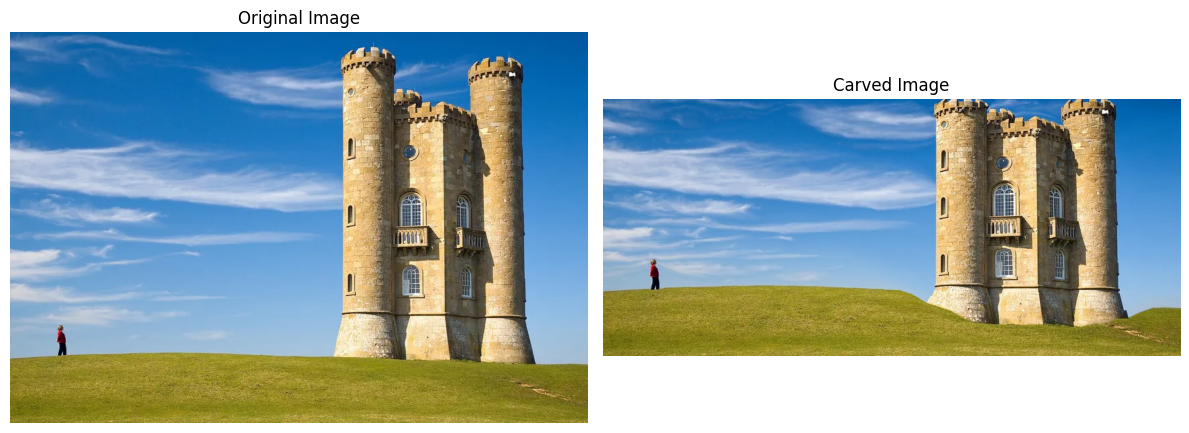

Original Image Shape: (583, 860, 3)
Carved Image Shape: (383, 860, 3)


In [13]:
# 1) Load the image
image = cv2.imread('broadway_original.webp')

# 2) Create a SeamCarver object
sc = SeamCarver(image)

# 3) Define the number of seams to remove
num_seams = 200

# 4) Perform seam carving
carved_image = sc.seam_carve(num_seams, method='l2',orientation=1) # 0 for vertical seams, 1 for horizontal seams

# 5) Display the original and carved images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(carved_image.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.title('Carved Image')
plt.axis('off')

plt.tight_layout()
plt.show()

print("Original Image Shape:", image.shape)
print("Carved Image Shape:", carved_image.shape)

Using the l2 method, the seam carving algorithm completed in 2 min 54 seconds.

In [14]:
cv2.imwrite("l2method.jpg", carved_image)

True

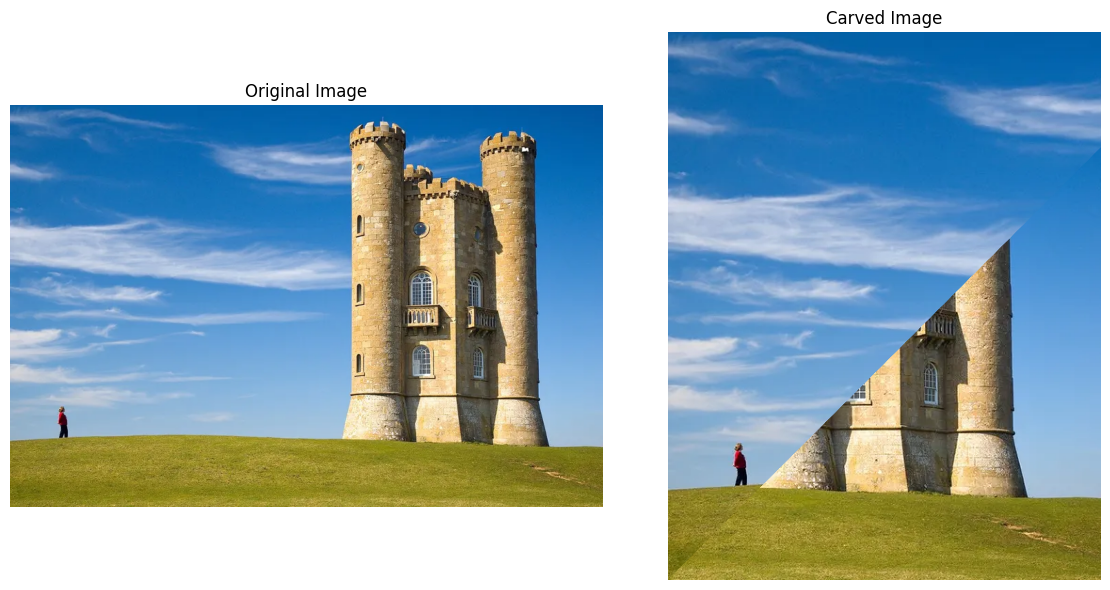

Original Image Shape: (583, 860, 3)
Carved Image Shape: (583, 460, 3)


In [12]:
# 1) Load the image
image = cv2.imread('broadway_original.webp')

# 2) Create a SeamCarver object
sc = SeamCarver(image)

# 3) Define the number of seams to remove
num_seams = 400

# 4) Perform seam carving
carved_image = sc.seam_carve(num_seams, method='entropy')

# 5) Display the original and carved images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(carved_image.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.title('Carved Image')
plt.axis('off')

plt.tight_layout()
plt.show()

print("Original Image Shape:", image.shape)
print("Carved Image Shape:", carved_image.shape)

Using the entropy method, the seam carving algorithm completed in 2 min 29 seconds.

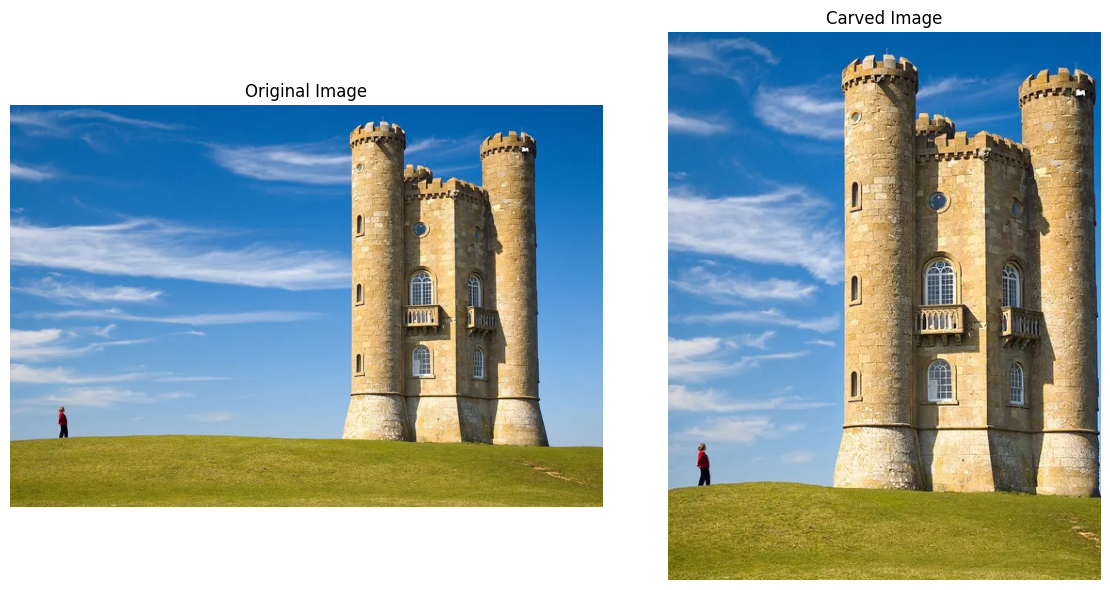

Original Image Shape: (583, 860, 3)
Carved Image Shape: (583, 460, 3)


In [13]:
# 1) Load the image
image = cv2.imread('broadway_original.webp')

# 2) Create a SeamCarver object
sc = SeamCarver(image)

# 3) Define the number of seams to remove
num_seams = 400

# 4) Perform seam carving
carved_image = sc.seam_carve(num_seams, method='skimage_HoG') # The HoG method whithout skimage is not working yet

# 5) Display the original and carved images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(carved_image.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.title('Carved Image')
plt.axis('off')

plt.tight_layout()
plt.show()

print("Original Image Shape:", image.shape)
print("Carved Image Shape:", carved_image.shape)

Using the HoG method with the simage librairie, the seam carving algorithm completed in 4 min 05 seconds.

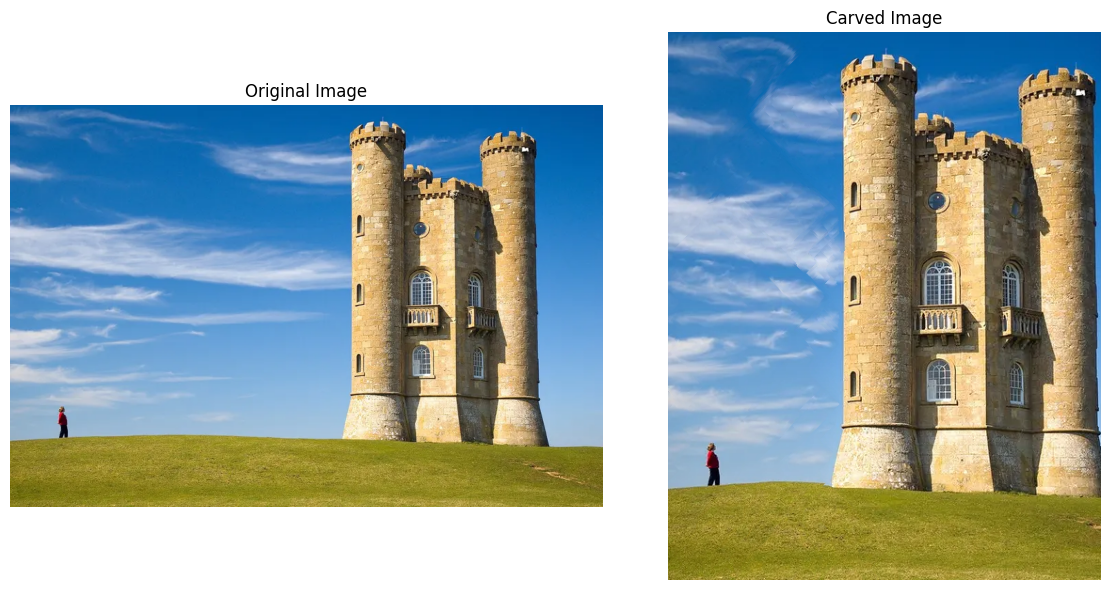

Original Image Shape: (583, 860, 3)
Carved Image Shape: (583, 460, 3)


In [14]:
# 1) Load the image
image = cv2.imread('broadway_original.webp')

# 2) Create a SeamCarver object
sc = SeamCarver(image)

# 3) Define the number of seams to remove
num_seams = 400

# 4) Perform seam carving
carved_image = sc.seam_carve(num_seams, method='skimage_entropy')

# 5) Display the original and carved images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(carved_image.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.title('Carved Image')
plt.axis('off')

plt.tight_layout()
plt.show()

print("Original Image Shape:", image.shape)
print("Carved Image Shape:", carved_image.shape)

Using the entropy method implemented with the skimage librairie, the seam carving algorithm completed in 4 min 21 seconds.

Saliency pour améliorer qualité image (on met la nouvelle carte d'énergie qu'on trouve grâce à la saliency en entrée de seam carving)


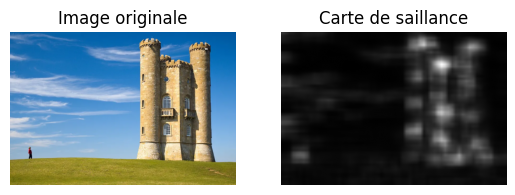

In [5]:
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 1) Load the image
image = cv2.imread('broadway_original.webp')

# 2) Create a SeamCarver object
sc = SeamCarver(image)

# 3) Define the number of seams to remove
num_seams = 400

# Création du détecteur de saillance
saliency = cv2.saliency.StaticSaliencySpectralResidual_create()

# Calcul de la carte de saillance
(success, saliencyMap) = saliency.computeSaliency(image)

# Normalisation pour visualisation
saliencyMap = (saliencyMap * 255).astype("uint8")

# Affichage
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title("Image originale")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(saliencyMap, cmap='gray')
plt.title("Carte de saillance")
plt.axis("off")

plt.show()



reduced_img = sc.seam_carve(num_seams, method='saliency')


sobel_energy = cv2.Sobel(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), cv2.CV_64F, 1, 0) ** 2 + \
 cv2.Sobel(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), cv2.CV_64F, 0, 1) ** 2
combined_energy = 0.5 * sobel_energy + 0.5 * saliencyMap


(np.float64(-0.5), np.float64(459.5), np.float64(582.5), np.float64(-0.5))

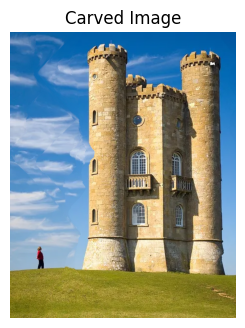

In [6]:
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(reduced_img.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.title('Carved Image')
plt.axis('off')

Saliency pour évaluer images (comparaison des résultats obtenus pour déterminer qui garde le mieux les zones les plus importantes de l'image)

In [8]:
from class_SeamCarver import compare_saliency_preservation

In [16]:
import os


# 1) Load the image
image = cv2.imread('broadway_original.webp')

# 2) Create a SeamCarver object
sc = SeamCarver(image)


# Appliquer seam carving avec plusieurs méthodes
reduced_images = {}


reduced_images = {
    "l1": cv2.imread("l1method.jpg"),
    "l2": cv2.imread("l2method.jpg")
}

compare_saliency_preservation(image, reduced_images)




Comparaison de la préservation de la saillance :
l2                        → score de saillance préservée : 17513.50
l1                        → score de saillance préservée : 17508.64


{'l1': np.float64(17508.64198196516), 'l2': np.float64(17513.495316021254)}